# ДЗ к уроку 6


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

# Для работы с матрицами
from scipy.sparse import csr_matrix

# Матричная факторизация
from implicit import als

# Модель второго уровня
from lightgbm import LGBMClassifier

import os, sys
module_path = os.path.abspath(os.path.join(os.pardir))
if module_path not in sys.path:
    sys.path.append(module_path)

# Написанные нами функции
from src.metrics import precision_at_k, recall_at_k
from src.utils import prefilter_items
from src.recommenders import MainRecommender

In [2]:
data = pd.read_csv('data/retail_train.csv')
item_features = pd.read_csv('data/product.csv')
user_features = pd.read_csv('data/hh_demographic.csv')

# column processing
item_features.columns = [col.lower() for col in item_features.columns]
user_features.columns = [col.lower() for col in user_features.columns]

item_features.rename(columns={'product_id': 'item_id'}, inplace=True)
user_features.rename(columns={'household_key': 'user_id'}, inplace=True)


# Важна схема обучения и валидации!
# -- давние покупки -- | -- 6 недель -- | -- 3 недель -- 
# подобрать размер 2-ого датасета (6 недель) --> learning curve (зависимость метрики recall@k от размера датасета)
val_lvl_1_size_weeks = 6
val_lvl_2_size_weeks = 3

data_train_lvl_1 = data[data['week_no'] < data['week_no'].max() - (val_lvl_1_size_weeks + val_lvl_2_size_weeks)]
data_val_lvl_1 = data[(data['week_no'] >= data['week_no'].max() - (val_lvl_1_size_weeks + val_lvl_2_size_weeks)) &
                      (data['week_no'] < data['week_no'].max() - (val_lvl_2_size_weeks))]

data_train_lvl_2 = data_val_lvl_1.copy()  # Для наглядности. Далее мы добавим изменения, и они будут отличаться
data_val_lvl_2 = data[data['week_no'] >= data['week_no'].max() - val_lvl_2_size_weeks]

data_train_lvl_1.head(2)

,user_id,basket_id,day,item_id,quantity,sales_value,store_id,retail_disc,trans_time,week_no,coupon_disc,coupon_match_disc
0,2375,26984851472,1,1004906,1,1.39,364,-0.6,1631,1,0.0,0.0
1,2375,26984851472,1,1033142,1,0.82,364,0.0,1631,1,0.0,0.0


In [3]:
n_items_before = data_train_lvl_1['item_id'].nunique()

data_train_lvl_1 = prefilter_items(data_train_lvl_1, item_features=item_features, take_n_popular=5000)

n_items_after = data_train_lvl_1['item_id'].nunique()
print('Decreased # items from {} to {}'.format(n_items_before, n_items_after))

Decreased # items from 83685 to 5001


In [4]:
recommender = MainRecommender(data_train_lvl_1)

In [5]:
recommender.get_als_recommendations(2375, N=5)

[899624, 1044078, 1106523, 5569230, 844179]

In [6]:
recommender.get_own_recommendations(2375, N=5)

[948640, 918046, 847962, 907099, 873980]

In [7]:
recommender.get_similar_items_recommendation(2375, N=5)

[1046545, 1044078, 1044078, 1072519, 846764]

In [8]:
recommender.get_similar_users_recommendation(2375, N=5)

[5574377, 974265, 1124971, 1101502, 10457044]

### Задание 1

A) Попробуйте различные варианты генерации кандидатов. Какие из них дают наибольший recall@k ?
- Пока пробуем отобрать 50 кандидатов (k=50)
- Качество измеряем на data_val_lvl_1: следующие 6 недель после трейна

Дают ли own recommendtions + top-popular лучший recall?  

B)* Как зависит recall@k от k? Постройте для одной схемы генерации кандидатов эту зависимость для k = {20, 50, 100, 200, 500}  
C)* Исходя из прошлого вопроса, как вы думаете, какое значение k является наиболее разумным?


#### A) Сравнение recall@k для разных методов

In [9]:
train_users_1 = data_train_lvl_1['user_id'].unique()

In [10]:
result_lvl_1 = data_val_lvl_1.groupby('user_id')['item_id'].unique().reset_index()
result_lvl_1 = result_lvl_1.query('user_id in @train_users_1')
result_lvl_1.columns=['user_id', 'actual']
result_lvl_1.head(2)

,user_id,actual
0,1,"[853529, 865456, 867607, 872137, 874905, 87524..."
1,2,"[15830248, 838136, 839656, 861272, 866211, 870..."


In [11]:
%%time
# Используем метод ALS
result_lvl_1['ALS'] = result_lvl_1['user_id'].apply(lambda x: recommender.get_als_recommendations(x, N=50))

Wall time: 37.2 s


In [12]:
%%time
# Используем метод own_recommendations
result_lvl_1['own_recommendations'] = result_lvl_1['user_id'].apply(lambda x: recommender.get_own_recommendations(x, N=50))

Wall time: 21.3 s


In [13]:
%%time
# Используем метод similar_items_recommendation
result_lvl_1['similar_items_recommendation'] = result_lvl_1['user_id'].apply(lambda x: recommender.get_similar_items_recommendation(x, N=50))

Wall time: 22 s


In [14]:
%%time
# Используем метод similar_users_recommendation
result_lvl_1['similar_users_recommendation'] = result_lvl_1['user_id'].apply(lambda x: recommender.get_similar_users_recommendation(x, N=50))

ValueError: userid is out of bounds of the user_items matrix

In [15]:
# Сравним recall для разных методов
print("ALS recall:", result_lvl_1.apply(lambda row: recall_at_k(row['ALS'], row['actual']), axis=1).mean())
print("own_recommendations recall:", result_lvl_1.apply(lambda row: recall_at_k(row['own_recommendations'], row['actual']), axis=1).mean())
print("similar_items_recommendation recall", result_lvl_1.apply(lambda row: recall_at_k(row['similar_items_recommendation'], row['actual']), axis=1).mean())
# print("similar_users_recommendation recall", result_lvl_1.apply(lambda row: recall_at_k(row['similar_users_recommendation'], row['actual']), axis=1).mean())

ALS recall: 0.012574757941352094
own_recommendations recall: 0.018201887674891032
similar_items_recommendation recall 0.0054772649133321945


In [16]:
result_lvl_1.head(3)

,user_id,actual,ALS,own_recommendations,similar_items_recommendation
0,1,"[853529, 865456, 867607, 872137, 874905, 87524...","[1096261, 1062572, 8090541, 1037332, 856942, 9...","[856942, 9297615, 5577022, 877391, 9655212, 88...","[824758, 826597, 9297615, 5577022, 1061747, 98..."
1,2,"[15830248, 838136, 839656, 861272, 866211, 870...","[5569230, 916122, 914577, 866211, 1040807, 865...","[911974, 1076580, 1103898, 5567582, 1056620, 9...","[1137346, 5569845, 1044078, 985999, 880888, 81..."
2,4,"[883932, 970760, 1035676, 1055863, 1097610, 67...","[821741, 1091383, 1075368, 880888, 1137010, 84...","[6391541, 1052294, 891423, 936470, 1137010, 11...","[938463, 973135, 7025250, 999714, 6514160, 702..."


#### B) Анализ зависимости recall@k от k

Будем анализировать зависимость recall@k от k для similar_items_recommendation.

In [17]:
k = {1, 2, 5, 10, 20, 100, 200, 500}

In [18]:
%%time
metrics = {}
name = 'similar_items_recommendation_{num}' # строка для наименования результатов вычисления метрик при разных k (num - это и есть k)
for k_ in k:
    name_k = name.format(num=k_)
    result_lvl_1[name_k] = result_lvl_1['user_id'].apply(lambda x: recommender.get_similar_items_recommendation(x, N=k_))
    metrics[k_] = result_lvl_1.apply(lambda row: recall_at_k(row[name_k], row['actual']), axis=1).mean()

Wall time: 3min 40s


In [19]:
metrics = dict(sorted(metrics.items()))
metrics

{1: 0.0012460725261050308,
 2: 0.002793103809660327,
 5: 0.0054772649133321945,
 10: 0.0054772649133321945,
 20: 0.0054772649133321945,
 100: 0.0054772649133321945,
 200: 0.0054772649133321945,
 500: 0.0054772649133321945}

Text(0, 0.5, 'recall@k')

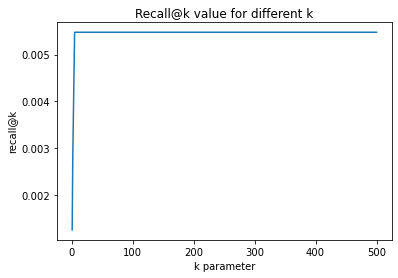

In [20]:
plt.plot(list(metrics.keys()), list(metrics.values()), label='test recall')
#plt.plot(list(metrics.keys()), list(metrics.values()), label='test recall')
plt.title('Recall@k value for different k')
plt.xlabel('k parameter')
plt.ylabel('recall@k')

#### C) Выбор оптимального значения k

Похоже, что оптимальным значением является k = 5. Далее recall уже перестает расти, однако увеличивается вычислительная нагрузка на систему. 

### Задание 2.

Обучите модель 2-ого уровня, при этом:
    - Добавьте минимум по 2 фичи для юзера, товара и пары юзер-товар
    - Измерьте отдельно precision@5 модели 1-ого уровня и двухуровневой модели на data_val_lvl_2
    - Вырос ли precision@5 при использовании двухуровневой модели?

In [21]:
users_lvl_2 = pd.DataFrame(data_train_lvl_2['user_id'].unique())
users_lvl_2.columns = ['user_id']

# Пока только warm start
train_users = data_train_lvl_1['user_id'].unique()
users_lvl_2 = users_lvl_2[users_lvl_2['user_id'].isin(train_users)]

In [22]:
# Будем использовать метод similar_items_recommendation
users_lvl_2['candidates'] = users_lvl_2['user_id'].apply(lambda x: recommender.get_similar_items_recommendation(x, N=50))

In [23]:
users_lvl_2.head(4)

,user_id,candidates
0,2070,"[1074754, 834117, 950202, 1004906, 857215, 101..."
1,2021,"[883932, 920654, 12301109, 13512542, 12301100,..."
2,1753,"[1044078, 9483647, 1022097, 1029743, 952163, 1..."
3,2120,"[1029743, 1106523, 5569230, 916122, 844179, 10..."


In [24]:
s = users_lvl_2.apply(lambda x: pd.Series(x['candidates']), axis=1).stack().reset_index(level=1, drop=True)
s.name = 'item_id'

users_lvl_2 = users_lvl_2.drop('candidates', axis=1).join(s)
users_lvl_2['flag'] = 1

users_lvl_2.head(4)

,user_id,item_id,flag
0,2070,1074754,1
0,2070,834117,1
0,2070,950202,1
0,2070,1004906,1


In [25]:
users_lvl_2.tail(4)

,user_id,item_id,flag
2153,1745,967461,1
2153,1745,1080989,1
2153,1745,825343,1
2153,1745,992650,1


In [26]:
targets_lvl_2 = data_train_lvl_2[['user_id', 'item_id']].copy()
targets_lvl_2['target'] = 1  # тут только покупки 

targets_lvl_2 = users_lvl_2.merge(targets_lvl_2, on=['user_id', 'item_id'], how='left')

targets_lvl_2['target'].fillna(0, inplace= True)
targets_lvl_2.drop('flag', axis=1, inplace=True)

In [27]:
targets_lvl_2.head(2)

,user_id,item_id,target
0,2070,1074754,0.0
1,2070,834117,1.0


In [28]:
targets_lvl_2['target'].mean()

0.056349366069631715

In [29]:
item_features.head(2)

,item_id,manufacturer,department,brand,commodity_desc,sub_commodity_desc,curr_size_of_product
0,25671,2,GROCERY,National,FRZN ICE,ICE - CRUSHED/CUBED,22 LB
1,26081,2,MISC. TRANS.,National,NO COMMODITY DESCRIPTION,NO SUBCOMMODITY DESCRIPTION,


In [30]:
user_features.head(2)

,age_desc,marital_status_code,income_desc,homeowner_desc,hh_comp_desc,household_size_desc,kid_category_desc,user_id
0,65+,A,35-49K,Homeowner,2 Adults No Kids,2,None/Unknown,1
1,45-54,A,50-74K,Homeowner,2 Adults No Kids,2,None/Unknown,7


In [31]:
data.head(3)

,user_id,basket_id,day,item_id,quantity,sales_value,store_id,retail_disc,trans_time,week_no,coupon_disc,coupon_match_disc
0,2375,26984851472,1,1004906,1,1.39,364,-0.6,1631,1,0.0,0.0
1,2375,26984851472,1,1033142,1,0.82,364,0.0,1631,1,0.0,0.0
2,2375,26984851472,1,1036325,1,0.99,364,-0.3,1631,1,0.0,0.0


Добавим фичу user_id: средний чек.

In [32]:
avg_check = data.groupby(['user_id']).sales_value.sum()/data.groupby(['user_id']).basket_id.count()
avg_check = avg_check.to_frame(name='avg_check')
user_features = user_features.merge(avg_check, on='user_id', how='left')

Добавим фичу user_id: средняя сумма покупок в самой популярной категории.

In [33]:
# Определим самую популярную категорию (по числу покупок). Получаем, что это категория grocery.
data_full = data.merge(item_features, on='item_id', how='left')
data_full.groupby(['department']).quantity.count().sort_values(ascending=False).head(3)

department
GROCERY    1519030
DRUG GM     255983
PRODUCE     238525
Name: quantity, dtype: int64

In [34]:
# Вычислим для каждого пользователя количество покупок в категории grocery
grocery_count = data_full.loc[data_full['department'] == 'GROCERY'].groupby(['user_id']).basket_id.count()
grocery_count = grocery_count.to_frame(name='grocery_count')
user_features = user_features.merge(grocery_count, on='user_id', how='left')
user_features.grocery_count.isna().sum()

0

In [35]:
# Проверим результат
user_features.head()

,age_desc,marital_status_code,income_desc,homeowner_desc,hh_comp_desc,household_size_desc,kid_category_desc,user_id,avg_check,grocery_count
0,65+,A,35-49K,Homeowner,2 Adults No Kids,2,None/Unknown,1,2.492077,1064
1,45-54,A,50-74K,Homeowner,2 Adults No Kids,2,None/Unknown,7,2.673405,670
2,25-34,U,25-34K,Unknown,2 Adults Kids,3,1,8,2.798250,1210
3,25-34,U,75-99K,Homeowner,2 Adults Kids,4,2,13,5.693402,1367
4,45-54,B,50-74K,Homeowner,Single Female,1,None/Unknown,16,2.927602,338


Добавим фичу item_id: среднее количество покупок товара в неделю.

In [36]:
avg_week_purchase = data.groupby('item_id').quantity.count() / (data.groupby('item_id').week_no.max() - data.groupby('item_id').week_no.min() + 1).sort_values()
avg_week_purchase = avg_week_purchase.to_frame(name='avg_week_purchase')

In [37]:
item_features = item_features.merge(avg_week_purchase, on='item_id', how='left')
item_features['avg_week_purchase'].fillna(0, inplace=True)
item_features.avg_week_purchase.isna().sum()

0

Добавим фичу item_id: цена.

In [38]:
# Вычислим цену на момент транзакции
data['price'] = data['sales_value'] / (np.maximum(data['quantity'], 1))

In [39]:
# Выберем последнюю по времени транзакции цену
transaction_time_price = data.groupby('item_id').trans_time.max()
transaction_time_price = transaction_time_price.to_frame()
transaction_time_price = transaction_time_price.merge(data[['price', 'item_id', 'trans_time']], on=['item_id', 'trans_time'], how='left')

In [40]:
transaction_time_price.head()

,item_id,trans_time,price
0,25671,2213,3.49
1,26081,936,0.99
2,26093,2034,1.59
3,26190,1342,1.54
4,26355,1411,0.99


In [41]:
# Добавим цену в item_features и заполним пропущенные значения нулями
item_features = item_features.merge(transaction_time_price, on='item_id', how='left')
item_features.drop('trans_time', axis=1, inplace=True)
item_features['price'].fillna(0, inplace=True)
item_features['price'].isna().sum()

0

In [42]:
item_features.head(3)

,item_id,manufacturer,department,brand,commodity_desc,sub_commodity_desc,curr_size_of_product,avg_week_purchase,price
0,25671,2,GROCERY,National,FRZN ICE,ICE - CRUSHED/CUBED,22 LB,0.081081,3.49
1,26081,2,MISC. TRANS.,National,NO COMMODITY DESCRIPTION,NO SUBCOMMODITY DESCRIPTION,,1.000000,0.99
2,26093,69,PASTRY,Private,BREAD,BREAD:ITALIAN/FRENCH,,1.000000,1.59


In [43]:
targets_lvl_2 = targets_lvl_2.merge(item_features, on='item_id', how='left')
targets_lvl_2 = targets_lvl_2.merge(user_features, on='user_id', how='left')

targets_lvl_2.head(2)

,user_id,item_id,target,manufacturer,department,brand,commodity_desc,sub_commodity_desc,curr_size_of_product,avg_week_purchase,price,age_desc,marital_status_code,income_desc,homeowner_desc,hh_comp_desc,household_size_desc,kid_category_desc,avg_check,grocery_count
0,2070,1074754,0.0,1075.0,GROCERY,National,COOKIES/CONES,SANDWICH COOKIES,18 OZ,6.956989,2.00,45-54,U,50-74K,Unknown,Unknown,1,None/Unknown,2.891039,1553.0
1,2070,834117,1.0,69.0,GROCERY,Private,WATER - CARBONATED/FLVRD DRINK,NON-CRBNTD DRNKING/MNERAL WATE,405.6 OZ,12.631579,3.99,45-54,U,50-74K,Unknown,Unknown,1,None/Unknown,2.891039,1553.0


Добавим фичу пары item_id - user_id: (Кол-во покупок юзером конкретной категории в неделю) / (Среднее кол-во покупок всеми юзерами конкретной категории в неделю)

In [44]:
# Вычислим среднее количество покупок юзером товара данной категории в неделю
user_avg_week_purchase = data_full.groupby(['user_id', 'department']).quantity.count() / (data_full.week_no.max() - data_full.week_no.min() + 1)
user_avg_week_purchase = user_avg_week_purchase.to_frame(name='user_avg_week_purchase')
user_avg_week_purchase.reset_index(inplace=True)
user_avg_week_purchase.head(3)

,user_id,department,user_avg_week_purchase
0,1,,0.126316
1,1,DELI,0.610526
2,1,DRUG GM,1.568421


In [45]:
# Вычислим среднее количество покупок всеми юзерами товара данной категории в неделю
all_avg_week_purchase = data_full.groupby(['department']).quantity.count() / (data_full.week_no.max() - data_full.week_no.min() + 1)
all_avg_week_purchase = all_avg_week_purchase.to_frame(name='all_avg_week_purchase')
all_avg_week_purchase.reset_index(inplace=True)
all_avg_week_purchase.head(3)

,department,all_avg_week_purchase
0,,75.894737
1,AUTOMOTIVE,0.621053
2,CHARITABLE CONT,0.021053


In [46]:
# Вычислим отношение двух показателей
# В датафрейм targets_lvl_2 добавим этот показатель позднее, после вычисления еще одной фичи.
avg_week_purchase = user_avg_week_purchase.merge(all_avg_week_purchase, on='department', how='left')
avg_week_purchase['ratio'] = avg_week_purchase['user_avg_week_purchase']/avg_week_purchase['all_avg_week_purchase']
avg_week_purchase.head(3)

,user_id,department,user_avg_week_purchase,all_avg_week_purchase,ratio
0,1,,0.126316,75.894737,0.001664
1,1,DELI,0.610526,611.484211,0.000998
2,1,DRUG GM,1.568421,2694.557895,0.000582


In [47]:
avg_week_purchase['ratio'].isna().sum()

0

Добавим фичу пары item_id - user_id: (Кол-во покупок юзером конкретной категории в неделю) - (Среднее кол-во покупок всеми юзерами конкретной категории в неделю)

In [48]:
avg_week_purchase['difference'] = avg_week_purchase['user_avg_week_purchase'] - avg_week_purchase['all_avg_week_purchase']

In [49]:
# Добавим два новых показателя в датафрейм targets_lvl_2
targets_lvl_2 = targets_lvl_2.merge(avg_week_purchase, on=['user_id', 'department'], how='left')
targets_lvl_2['ratio'].fillna(0, inplace=True)
targets_lvl_2['difference'].fillna(0, inplace=True)
targets_lvl_2.drop('user_avg_week_purchase', axis=1, inplace=True)
targets_lvl_2.drop('all_avg_week_purchase', axis=1, inplace=True)
targets_lvl_2.head(3)

,user_id,item_id,target,manufacturer,department,brand,commodity_desc,sub_commodity_desc,curr_size_of_product,avg_week_purchase,...,marital_status_code,income_desc,homeowner_desc,hh_comp_desc,household_size_desc,kid_category_desc,avg_check,grocery_count,ratio,difference
0,2070,1074754,0.0,1075.0,GROCERY,National,COOKIES/CONES,SANDWICH COOKIES,18 OZ,6.956989,...,U,50-74K,Unknown,Unknown,1,None/Unknown,2.891039,1553.0,0.001022,-15973.442105
1,2070,834117,1.0,69.0,GROCERY,Private,WATER - CARBONATED/FLVRD DRINK,NON-CRBNTD DRNKING/MNERAL WATE,405.6 OZ,12.631579,...,U,50-74K,Unknown,Unknown,1,None/Unknown,2.891039,1553.0,0.001022,-15973.442105
2,2070,950202,0.0,69.0,DELI,Private,SANDWICHES,SANDWICHES - (COLD),,0.716049,...,U,50-74K,Unknown,Unknown,1,None/Unknown,2.891039,1553.0,0.000413,-611.231579


In [50]:
X_train = targets_lvl_2.drop('target', axis=1)
y_train = targets_lvl_2[['target']]

In [51]:
X_train.columns

Index(['user_id', 'item_id', 'manufacturer', 'department', 'brand',
       'commodity_desc', 'sub_commodity_desc', 'curr_size_of_product',
       'avg_week_purchase', 'price', 'age_desc', 'marital_status_code',
       'income_desc', 'homeowner_desc', 'hh_comp_desc', 'household_size_desc',
       'kid_category_desc', 'avg_check', 'grocery_count', 'ratio',
       'difference'],
      dtype='object')

In [52]:
cat_feats = ['manufacturer', 'department', 'brand', 'commodity_desc', 'sub_commodity_desc', 'curr_size_of_product','age_desc', 
             'marital_status_code', 'income_desc', 'homeowner_desc', 'hh_comp_desc', 'household_size_desc', 'kid_category_desc']
X_train[cat_feats] = X_train[cat_feats].astype('category')

cat_feats

['manufacturer',
 'department',
 'brand',
 'commodity_desc',
 'sub_commodity_desc',
 'curr_size_of_product',
 'age_desc',
 'marital_status_code',
 'income_desc',
 'homeowner_desc',
 'hh_comp_desc',
 'household_size_desc',
 'kid_category_desc']

In [53]:
lgb = LGBMClassifier(objective='binary', max_depth=7, categorical_column=cat_feats, random_state=1)
lgb.fit(X_train, y_train)

train_preds = lgb.predict(X_train)

C:\Users\krasc_000\anaconda3\lib\site-packages\sklearn\utils\validation.py:73: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\Users\krasc_000\anaconda3\lib\site-packages\lightgbm\basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


Берем топ-k предсказаний, ранжированных по вероятности, для каждого юзера

In [54]:
train_preds.sum()

2179.0

In [55]:
y_train['target'].sum()

7184.0

#### Валидация второй модели

Получим предсказания по первой модели для data_val_lvl_2.

In [56]:
users_lvl_2_val = pd.DataFrame(data_val_lvl_2['user_id'].unique())
users_lvl_2_val.columns = ['user_id']

# Пока только warm start
users_lvl_2_val = users_lvl_2_val[users_lvl_2_val['user_id'].isin(train_users)]

In [57]:
users_lvl_2_val['candidates'] = users_lvl_2_val['user_id'].apply(lambda x: recommender.get_similar_items_recommendation(x, N=50))

In [58]:
s = users_lvl_2_val.apply(lambda x: pd.Series(x['candidates']), axis=1).stack().reset_index(level=1, drop=True)
s.name = 'item_id'

users_lvl_2_val = users_lvl_2_val.drop('candidates', axis=1).join(s)

users_lvl_2_val.head(4)

,user_id,item_id
0,338,952163
0,338,970160
0,338,6979393
0,338,13002975


In [59]:
preds_2 = users_lvl_2_val.merge(item_features, on='item_id', how='left')
preds_2 = preds_2.merge(user_features, on='user_id', how='left')

preds_2.head(2)

,user_id,item_id,manufacturer,department,brand,commodity_desc,sub_commodity_desc,curr_size_of_product,avg_week_purchase,price,age_desc,marital_status_code,income_desc,homeowner_desc,hh_comp_desc,household_size_desc,kid_category_desc,avg_check,grocery_count
0,338,952163,69.0,PRODUCE,Private,POTATOES,POTATOES RUSSET (BULK&BAG),5 LB,11.362069,2.99,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,338,970160,759.0,GROCERY,National,YOGURT,YOGURT NOT MULTI-PACKS,32 OZ,2.076087,2.69,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Фичи для user и item были добавлены ранее. Осталось добавить фичи для пар user-item.

In [60]:
preds_2 = preds_2.merge(avg_week_purchase, on=['user_id', 'department'], how='left')
preds_2['ratio'].fillna(0, inplace=True)
preds_2['difference'].fillna(0, inplace=True)
preds_2.drop('user_avg_week_purchase', axis=1, inplace=True)
preds_2.drop('all_avg_week_purchase', axis=1, inplace=True)
preds_2.head(3)

,user_id,item_id,manufacturer,department,brand,commodity_desc,sub_commodity_desc,curr_size_of_product,avg_week_purchase,price,...,marital_status_code,income_desc,homeowner_desc,hh_comp_desc,household_size_desc,kid_category_desc,avg_check,grocery_count,ratio,difference
0,338,952163,69.0,PRODUCE,Private,POTATOES,POTATOES RUSSET (BULK&BAG),5 LB,11.362069,2.99,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.001245,-2507.663158
1,338,970160,759.0,GROCERY,National,YOGURT,YOGURT NOT MULTI-PACKS,32 OZ,2.076087,2.69,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000261,-15985.621053
2,338,6979393,2844.0,MEAT,National,BEEF,FLANK,,1.033333,3.04,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.001125,-860.021053


In [61]:
X_val = preds_2

In [62]:
X_val[cat_feats] = X_val[cat_feats].astype('category')

In [63]:
test_preds = lgb.predict_proba(X_val)

In [64]:
preds_2['proba'] = test_preds[:, 1]

In [65]:
recommendations = preds_2[['user_id', 'item_id', 'proba']]

In [66]:
lgbm_recs = pd.DataFrame(recommendations.sort_values(['user_id', 'proba'], ascending=False).groupby('user_id')\
             .apply(lambda x: x['item_id'].iloc[:5].values)).rename(columns={0:'lgbm'})

In [67]:
lgbm_recs = lgbm_recs.merge(
    pd.DataFrame(
        data_val_lvl_2.groupby('user_id')['item_id'].unique()).rename(columns={'item_id':'actual'}).reset_index(),\
    on='user_id', how='left')
lgbm_recs.head(3)   

,user_id,lgbm,actual
0,1,"[8293439, 9297615, 5577022, 1138443, 968164]","[821867, 834484, 856942, 865456, 889248, 90795..."
1,3,"[1029743, 1029743, 1029743, 1029743, 1044078]","[835476, 851057, 872021, 878302, 879948, 90963..."
2,6,"[878996, 878996, 901062, 878715, 1105488]","[920308, 926804, 946489, 1006718, 1017061, 107..."


In [68]:
lgbm_recs.apply(lambda x: precision_at_k(x['lgbm'], x['actual']), axis=1).mean()*100

9.872549019607789

Оценим precision@5 для первой модели.

In [69]:
users_lvl_2_val = pd.DataFrame(data_val_lvl_2['user_id'].unique())
users_lvl_2_val.columns = ['user_id']

# Пока только warm start
users_lvl_2_val = users_lvl_2_val[users_lvl_2_val['user_id'].isin(train_users)]

In [70]:
users_lvl_2_val['candidates'] = users_lvl_2_val['user_id'].apply(lambda x: recommender.get_similar_items_recommendation(x, N=5))

In [71]:
users_lvl_2_val.head()

,user_id,candidates
0,338,"[952163, 970160, 6979393, 13002975, 1074754]"
1,2120,"[1029743, 1106523, 5569230, 916122, 844179]"
2,2324,"[1074754, 8090545, 879876, 6463742, 851683]"
3,514,"[914346, 1135476, 820341, 906923, 1105488]"
4,1762,"[1074754, 1029743, 926905, 1105488, 952972]"


In [72]:
lgbm_recs = lgbm_recs.merge(users_lvl_2_val, on='user_id', how='left')

In [73]:
lgbm_recs

,user_id,lgbm,actual,candidates
0,1,"[8293439, 9297615, 5577022, 1138443, 968164]","[821867, 834484, 856942, 865456, 889248, 90795...","[824758, 826597, 9297615, 5577022, 1061747]"
1,3,"[1029743, 1029743, 1029743, 1029743, 1044078]","[835476, 851057, 872021, 878302, 879948, 90963...","[1044078, 1024051, 945998, 839419, 999714]"
2,6,"[878996, 878996, 901062, 878715, 1105488]","[920308, 926804, 946489, 1006718, 1017061, 107...","[948650, 5569845, 819308, 941361, 1074754]"
3,7,"[1029743, 1029743, 9802756, 1044078, 865174]","[840386, 889774, 898068, 909714, 929067, 95347...","[959830, 1044078, 982469, 995478, 13072944]"
4,8,"[1029743, 1029743, 1044078, 1044078, 9835509]","[835098, 872137, 910439, 924610, 992977, 10412...","[5569845, 5569374, 1044078, 6602440, 938300]"
...,...,...,...,...
2035,2496,"[916122, 916122, 916122, 899624, 899624]",[6534178],"[985999, 5569845, 990797, 1070702, 1044078]"
2036,2497,"[1042765, 899624, 916122, 916122, 916122]","[1016709, 9835695, 1132298, 16809501, 845294, ...","[841309, 865026, 928640, 850102, 999198]"
2037,2498,"[5568378, 1005274, 9856740, 1009187, 5568729]","[15716530, 834484, 901776, 914190, 958382, 972...","[944836, 901062, 1063577, 13008412, 1033372]"
2038,2499,"[5568378, 913210, 908064, 5568729, 1004436]","[867188, 877580, 902396, 914190, 951590, 95813...","[901062, 6534480, 907631, 1027642, 12301109]"


In [74]:
lgbm_recs.apply(lambda x: precision_at_k(x['candidates'], x['actual']), axis=1).mean()*100

4.823529411764739

Как видим, после применения второй модели precision@5 вырос с 4.82 до 9.87.